# Predire stipendio di impieghi in Data Science

**Progetto di Programmazione di Applicazioni Data Intensive**   
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Studente Corrado Stortini   
`corrado.stortini2@studio.unibo.it`

## Setup

- Importare i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Introduzione

- L'obbiettivo è quello di predire lo stipendio annuale (in dollari) di un lavoratore nel campo della Data Science
- Il dataset usato è _Data Science Salaries 2023_, reperibile su [_Kaggle_](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023)
- Il dataset completo è composto da 11 variabili, di cui 2 di target (stipendio e stipendio in dollari), ma dato che l'importanza dello stipendio generale dipende dal tipo della valuta, si è deciso di non considerare il target "stipendio"
- Un'altra variabile che non verrà considerata è proprio il tipo della valuta (dollari, euro, sterline ecc.), dato che non offre informazioni per la predizione dello stipendio annuale (servirebbe solamente per capire "l'importanza" del numero in "stipendio", per es. 1000 euro hanno una capacità di acquisto diversa da 1000 sterline o 1000 dollari)


In [7]:
salaries = pd.read_csv("ds_salaries.csv")
salaries.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,USD,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,USD,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,USD,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,USD,147100,US,0,US,M


In [35]:
features = ["work_year", "experience_level", "employment_type", "job_title", "employee_residence", "remote_ratio", "company_location", "company_size"]

X = salaries[features]
y = salaries["salary_in_usd"]

## Spiegazione attributi

- *work_year* indica in che anno il lavoratore prende lo stipendio (potrebbe incidere nello stipendio per esempio si potrebbe notare, secondo una mia ipotesi, che se uno stipendio appartiene al 2020, allora sarà più basso per via del Covid)
- *experience_level* indica il livello di esperienza del lavoratore 
    - EN -> Entry-level, junior; 
    - MI -> Mid-level, Intermediate; 
    - SE -> Senior-level, Expert;
    - EX -> Executive-level, Director.  
- *employment_type* indica il tipo di impiego
    - PT -> Part-time;
    - FT -> Full-time;
    - CT -> Contract;
    - FL -> Freelance.
- *job_title* indica il titolo dell'impiego
- *employee_residence* è lo stato in cui risiede il lavoratore
- *remote_ratio* percentuale di lavoro effettuato da remoto
- *company_location* località dell'azienda del lavoratore
- *company_size* dimensione dell'azienda

Non ci sono dati mancanti o errati nel dataset come riportato nelle statistiche sul [sito](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023)

Un identificativo numerico è utilizzato come indice per le righe

## Esplorazione Dataset

Diamo ora un'occhiata a varie statistiche generali nel dataset come media dello stipendio, numero di istanze e così via.

**Numero di istanze**

In [38]:
y.count()

3755

**Numero di istanze per ogni company_location**

In [40]:
X["company_location"].value_counts()

US    3040
GB     172
CA      87
ES      77
IN      58
      ... 
MK       1
BS       1
IR       1
CR       1
MT       1
Name: company_location, Length: 72, dtype: int64

- Si può per esempio notare che la maggior parte dei dati sono presi negli US

**Numero di istanze per anno**

In [41]:
X["work_year"].value_counts()

2023    1785
2022    1664
2021     230
2020      76
Name: work_year, dtype: int64

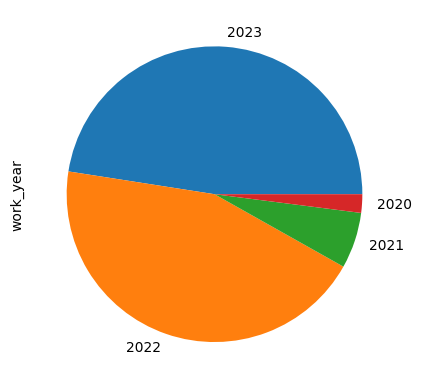

In [42]:
X["work_year"].value_counts().plot.pie();

**Numero di istanze per esperienza di lavoro**

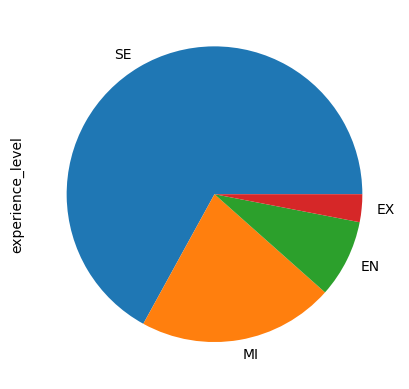

In [65]:
X["experience_level"].value_counts().plot.pie();

**Remote ratio**

In [67]:
X["remote_ratio"].value_counts()

0      1923
100    1643
50      189
Name: remote_ratio, dtype: int64

- Si può notare che in remote ratio ci sono solo 3 tipi di valori: 0, 50 e 100

**Esplorazione salari**

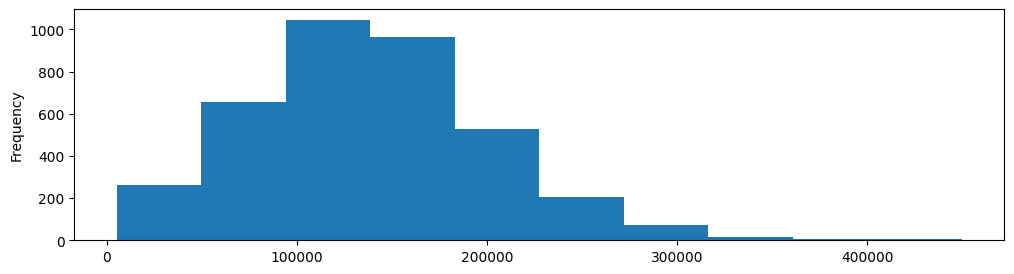

In [75]:
y.plot.hist(figsize=(12,3));

- Si può notare che la maggior parte degli stipendi sono intorno ai 10-20 mila dollari annui, infatti:

In [78]:
y.mean()

137570.38988015978

- Essendo tutte le variabili predittive di tipo categorico, la variabile di target è l'unica di cui ha senso fare un'analisi delle statistiche come media, deviazione standard ecc.

In [79]:
y.describe()

count      3755.000000
mean     137570.389880
std       63055.625278
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

**Top 10 di lavori mediamente più pagati**

In [106]:
job_salaries = salaries.groupby("job_title")["salary_in_usd"].mean()
job_salaries.sort_values(ascending = False).head(10)

job_title
Data Science Tech Lead                375000.000000
Cloud Data Architect                  250000.000000
Data Lead                             212500.000000
Data Analytics Lead                   211254.500000
Principal Data Scientist              198171.125000
Director of Data Science              195140.727273
Principal Data Engineer               192500.000000
Machine Learning Software Engineer    192420.000000
Data Science Manager                  191278.775862
Applied Scientist                     190264.482759
Name: salary_in_usd, dtype: float64